In [ ]:
#@title foo
!pip install transformers==4.1.1 plotnine

## setting stuff up

In [1]:
import re
import itertools

import numpy as np
import pandas as pd

from IPython.display import HTML
import plotnine
from plotnine import *

import torch
from transformers import AutoModel, AutoTokenizer

plotnine.options.figure_size = (20, 20)

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
# uncomment to force CPU if you have a GPU but not enough memory to do what you want. it will be slow of course

#device = torch.device("cpu")

In [3]:
#transformer = "distilbert-base-cased"
transformer = "bert-base-cased"
#transformer = "gpt2"
#transformer = "gpt2-medium"
#transformer = "gpt2-large"
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(transformer)
model = AutoModel.from_pretrained(transformer, output_attentions=True, output_hidden_states=True)
model.to(device)
model.eval()
model.zero_grad()


## data preparation

In [4]:
sentences = [
    "This is a really long sentence that doesn't make much sense, but let's see what happens at the end",
    "There are five subspecies of the pigeon guillemot; all subspecies, when in breeding plumage, are dark brown with a black iridescent sheen and a distinctive wing patch broken by a brown-black wedge.",
    "Buchanan, working through federal patronage appointees in Illinois, ran candidates for the legislature in competition with both the Republicans and the Douglas Democrats.",
#    "Less is more.",
]

# gpt2 doesn't do padding, so invent a padding token
# this one was suggested by the error you get when trying
# to do masking below, but it shouldn't matter as the actual
# tokens get ignored by the attention mask anyway
if transformer in ['gpt2', 'gpt2-medium', 'gpt2-large']:
    tokenizer.pad_token = tokenizer.eos_token

input_dict = tokenizer(sentences, padding=True, return_tensors="pt")
for k, v in input_dict.items():
    input_dict[k] = v.to(device)
print(input_dict)

{'input_ids': tensor([[  101,  1188,  1110,   170,  1541,  1263,  5650,  1115,  2144,   112,
           189,  1294,  1277,  2305,   117,  1133,  1519,   112,   188,  1267,
          1184,  5940,  1120,  1103,  1322,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1247,  1132,  1421, 11332,  1104,  1103, 27936,   176, 16966,
         14183,  3329,   132,  1155, 11332,   117,  1165,  1107,  8103,   185,
          7776,  2553,   117,  1132,  1843,  3058,  1114,   170,  1602,   178,
         17731, 23193,  1131,  1424,  1105,   170,  7884,  3092, 10085,  3088,
          1118,   170,  3058,   118,  1602, 22432,   119,   102],
        [  101, 14912,   117,  1684,  1194,  2877, 17326, 18016,  8870,  1107,
          3461,   117,  1868,  4765,  1111,  1103,  8312,  1107,  2208,  1114,
          1241,  1103, 11115,  1105,  1103,  4402,  7834,   119,

In [5]:
output = model(**input_dict)

In [6]:
att = np.array([a.cpu().detach().numpy() for a in output['attentions']])
print(att.shape)

(12, 3, 12, 48, 48)


## getting the data ready to plot

In [7]:
# use the attention mask to flag the padding tokens
att_mask = input_dict['attention_mask'].cpu().detach()
print(att_mask.shape)
print(att_mask.sum())

torch.Size([3, 48])
tensor(103)


In [8]:
att = att.swapaxes(2,1)
print(att.shape)

(12, 12, 3, 48, 48)


In [9]:
# make the dimension indices of the array explicit as
# a pandas dataframe MultiIndex
spec = att.shape
dims = {}
for dim, size in reversed(list(enumerate(spec))):
    if dim == len(spec) - 1:
        dims[dim] = np.arange(size) + 1
    else:
        for d in range(dim + 1, len(spec)):
            dims[d] = np.tile(dims[d], size)
        dims[dim] = np.repeat(np.arange(size) + 1, np.prod(spec[dim+1:]))

ix = pd.MultiIndex.from_arrays(list(dims.values()), names=reversed(['layer', 'head', 'sentence', 'from_token', 'to_token']))

In [ ]:
print(ix)

In [10]:
df = pd.DataFrame(
        att.flatten(), # turn the array into one long list of numbers
        columns=["attention_fraction"], 
        index=ix, # indexed by its dimensions
    ).reset_index() # and then turn the dimensions into columns
display(df)

,to_token,from_token,sentence,head,layer,attention_fraction
0,1,1,1,1,1,0.553507
1,2,1,1,1,1,0.015439
2,3,1,1,1,1,0.003561
3,4,1,1,1,1,0.021966
4,5,1,1,1,1,0.003492
...,...,...,...,...,...,...
995323,44,48,3,12,12,0.000000
995324,45,48,3,12,12,0.000000
995325,46,48,3,12,12,0.000000
995326,47,48,3,12,12,0.000000


In [ ]:
# filter out the masked tokens
for sentence, toklist in enumerate(att_mask.tolist()):
    # the next two lines filter out the first and last unmasked token which are [CLS] and [SEP] (for bert)
    # comment them out to see the results with them included
    final = max(np.nonzero(toklist)[0])
    modified = [0] + toklist[1:final] + [0] + toklist[final+1:]
    for token in [i for i, v in enumerate(modified) if v == 0]:
        df = df.query(f"~(sentence == {sentence + 1} & (to_token == {token + 1} | from_token == {token + 1}))")


### calculate the weighted distances and their median per head

In [40]:
df['distance'] = (df['from_token'] - df['to_token'])
df['sign'] = df['distance'] > 0

In [41]:
display(df)

,to_token,from_token,sentence,head,layer,attention_fraction,distance,weighted,sign
0,1,1,1,1,1,0.553507,0,0.000000,False
1,2,1,1,1,1,0.015439,-1,-0.015439,False
2,3,1,1,1,1,0.003561,-2,-0.007123,False
3,4,1,1,1,1,0.021966,-3,-0.065897,False
4,5,1,1,1,1,0.003492,-4,-0.013967,False
...,...,...,...,...,...,...,...,...,...
995323,44,48,3,12,12,0.000000,4,0.000000,True
995324,45,48,3,12,12,0.000000,3,0.000000,True
995325,46,48,3,12,12,0.000000,2,0.000000,True
995326,47,48,3,12,12,0.000000,1,0.000000,True


In [42]:
# show the data for the second token of the first sentence for the first layer and the first head
# which is really the first one in the data as I filter out [CLS] above
with pd.option_context("max_rows", None):
    display(df.query("layer == 1 & head == 1 & sentence == 1 & from_token == 2").sort_values("attention_fraction", ascending=False))

,to_token,from_token,sentence,head,layer,attention_fraction,distance,weighted,sign
56,9,2,1,1,1,0.084931,-7,-0.594518,False
54,7,2,1,1,1,0.082073,-5,-0.410367,False
70,23,2,1,1,1,0.071712,-21,-1.505954,False
73,26,2,1,1,1,0.071234,-24,-1.709626,False
48,1,2,1,1,1,0.069239,1,0.069239,True
67,20,2,1,1,1,0.066207,-18,-1.191733,False
69,22,2,1,1,1,0.063823,-20,-1.276465,False
72,25,2,1,1,1,0.054215,-23,-1.246937,False
50,3,2,1,1,1,0.050670,-1,-0.050670,False
49,2,2,1,1,1,0.039944,0,0.000000,False


In [43]:
df['weighted'] = df['distance'] * df['attention_fraction']

In [44]:
g = df.groupby(['layer', 'head', 'sign'])
median_dist = (g['weighted'].median()).reset_index().round(3)

In [45]:
display(median_dist)

,layer,head,sign,weighted
0,1,1,False,-0.018
1,1,1,True,0.225
2,1,2,False,-0.005
3,1,2,True,0.086
4,1,3,False,-0.036
...,...,...,...,...
283,12,10,True,0.030
284,12,11,False,-0.000
285,12,11,True,0.013
286,12,12,False,-0.001


## plot

Cheat a bit by limiting the plots to show only the interval between 0 and 2 for the weighted distance. 

This unsquishes the violins to reveal a pattern a bit similar to the plot of `k` in the Hopfields networks
paper, but it does hide values (especially for the dot plot), which may give a false impression

you can change the interval by adjusting the limits variable

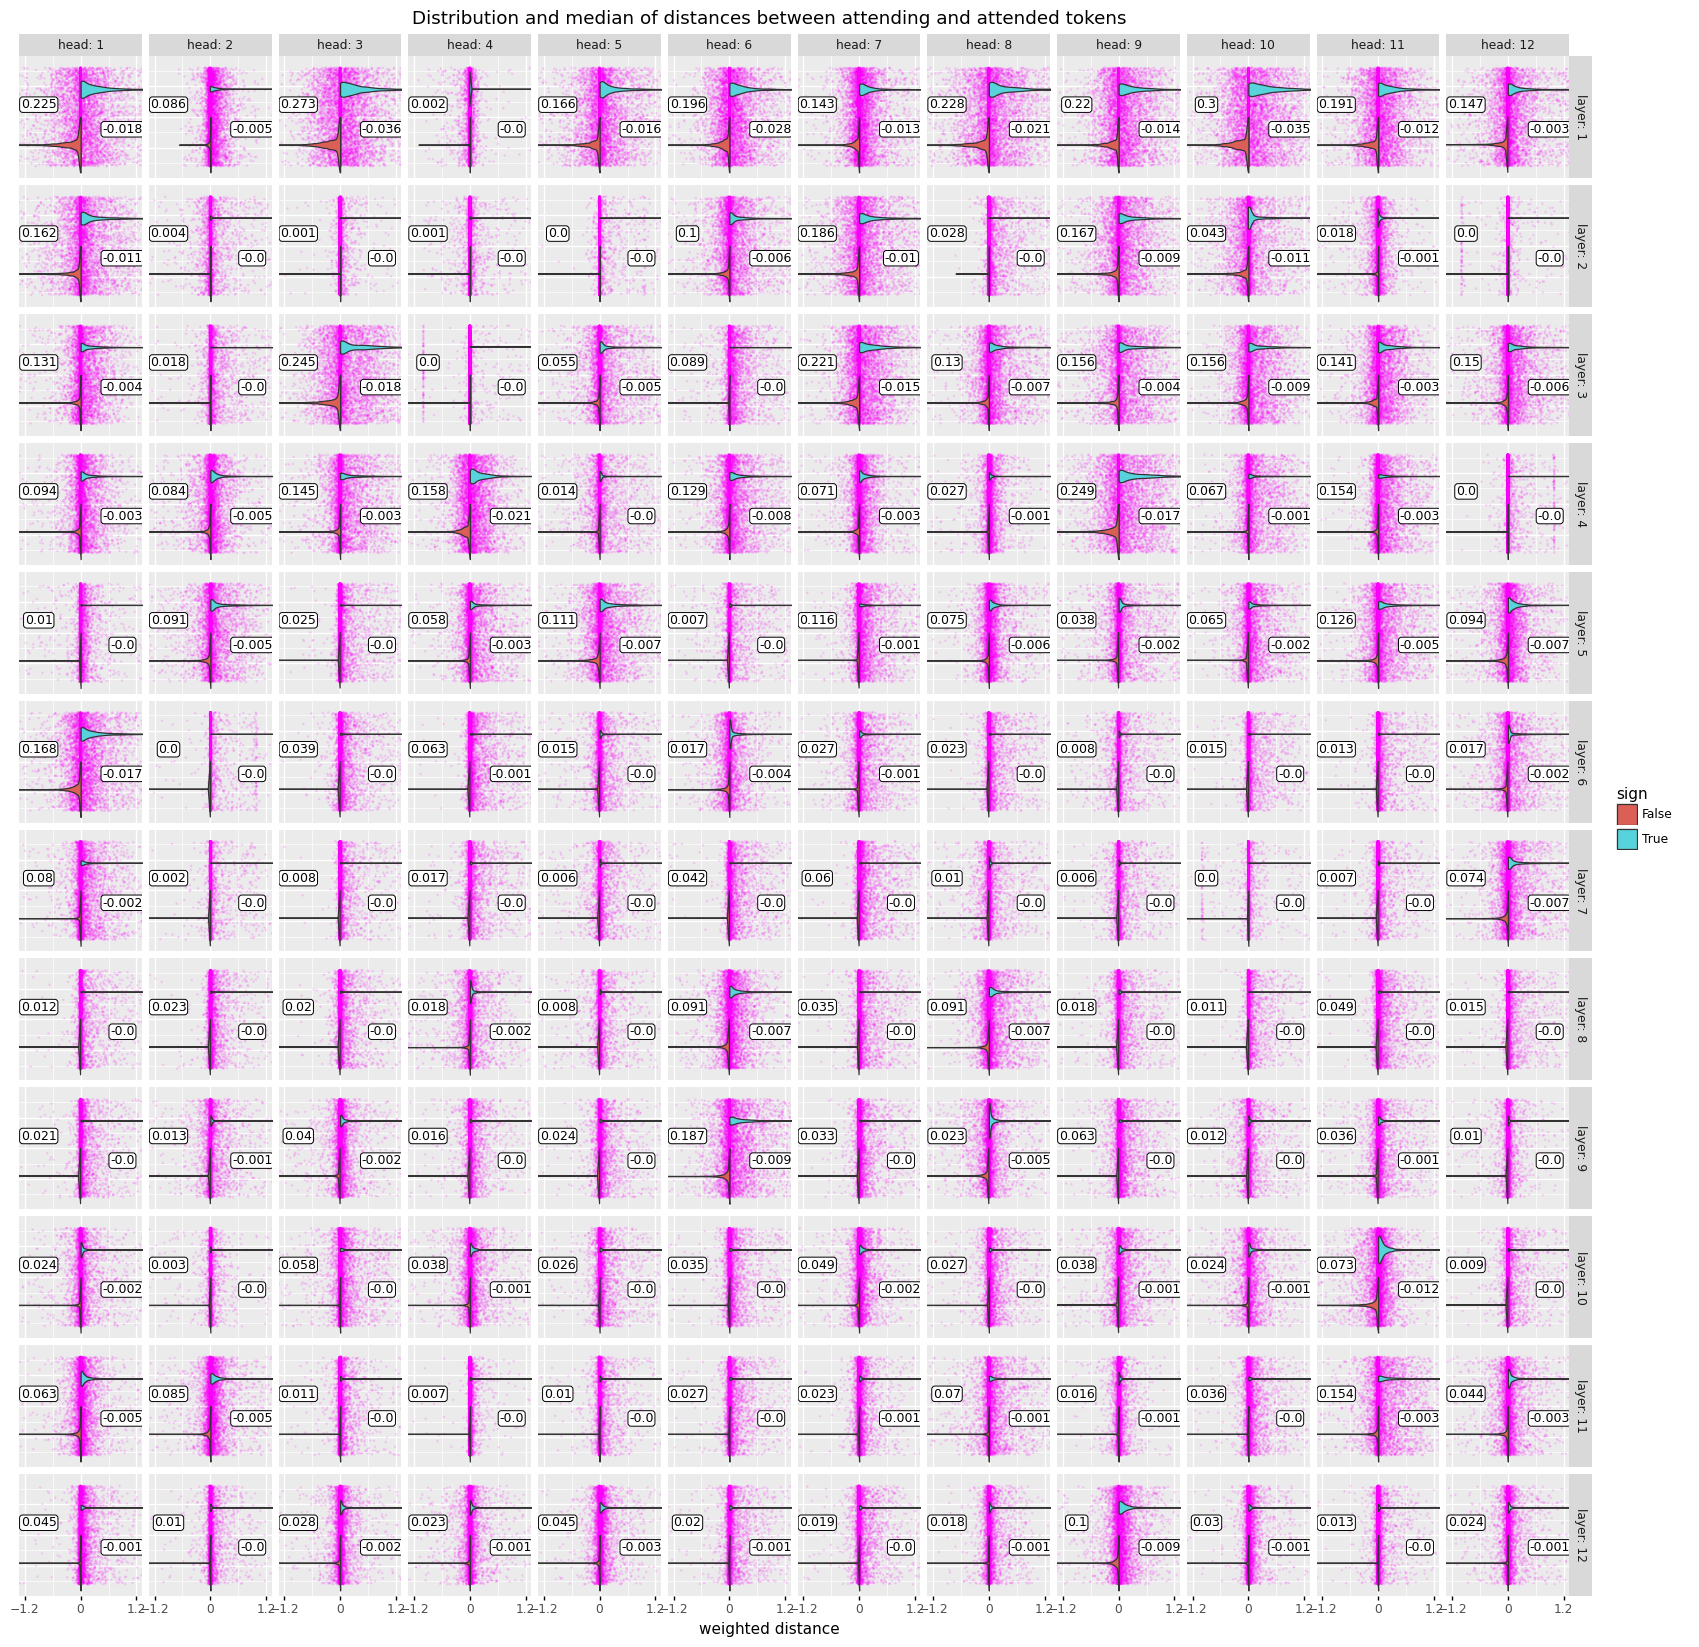

<ggplot: (8733155403301)>

In [47]:
# plot it!
limits = (-1.2, 1.2)
plotnine.options.figure_size = (20, 20)
(ggplot(df, aes(1, "weighted"))  + 
     geom_jitter(height=0, size=0.1, alpha=0.1, color="magenta") +
     geom_violin(mapping=aes(fill="sign")) +
     geom_label(data=median_dist[median_dist['sign'] == True], mapping=aes(x=1.1, y=limits[0] * .75, label="weighted"), label_padding=0.1, size=9) +
     geom_label(data=median_dist[median_dist['sign'] == False], mapping=aes(x=0.9, y=limits[1] * .75, label="weighted"), label_padding=0.1, size=9) +
     scale_y_continuous(breaks=np.linspace(*limits, num=3)) +
     facet_grid("layer ~ head", labeller="label_both") + 
     coord_flip(ylim=limits) +
     labs(
             x = "",
             y = "weighted distance",
             title = "Distribution and median of distances between attending and attended tokens"
         ) +
     theme(
             axis_text_y = element_blank(),
             axis_ticks_major_y = element_blank()
         )
)

### subset of heads

plot only a few heads, so each facet can be bigger and it's not as neccesary to limit what is shown

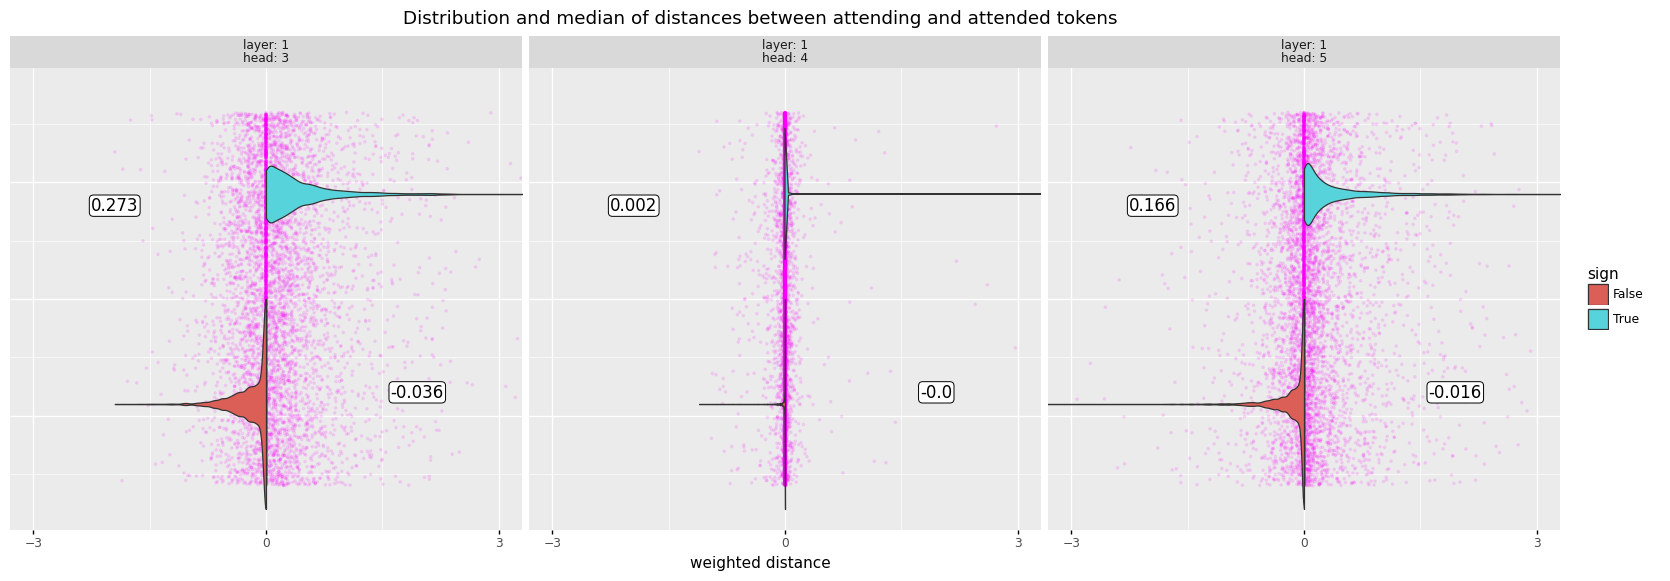

<ggplot: (8733156649951)>

In [52]:
subset = "layer == 1 & head >= 3 & head <= 5"
plotnine.options.figure_size = (20, 6)
limits=(-3,3)
(ggplot(df.query(subset), aes(1, "weighted"))  + 
     geom_jitter(height=0, size=0.5, alpha=0.1, color="magenta") +
     geom_violin(mapping=aes(fill="sign")) +
     geom_label(data=median_dist[median_dist['sign'] == True].query(subset), mapping=aes(x=1.2, y=limits[0] * .65, label="weighted"), label_padding=0.1, size=12) +
     geom_label(data=median_dist[median_dist['sign'] == False].query(subset), mapping=aes(x=0.8, y=limits[1] * .65, label="weighted"), label_padding=0.1, size=12) +
     scale_y_continuous(breaks=np.linspace(*limits, num=3)) +
     facet_wrap("~ layer + head", labeller="label_both") + 
     coord_flip(
             ylim=limits
         ) +
     labs(
             x = "",
             y = "weighted distance",
             title = "Distribution and median of distances between attending and attended tokens"
         ) +
     theme(
             axis_text_y = element_blank(),
             axis_ticks_major_y = element_blank()
         )
)